In [54]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons, load_iris
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

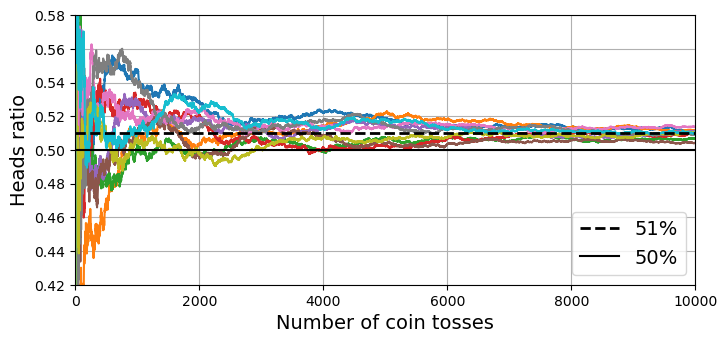

In [55]:
# extra code – this cell generates figures
np.random.seed(42)
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()

In [56]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(random_state=42)),
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [57]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.824
svc = 0.896


In [58]:
voting_clf.predict(X_test[:1])

array([1])

In [59]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [60]:
voting_clf.score(X_test, y_test)

0.88

In [61]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


0.912

In [62]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

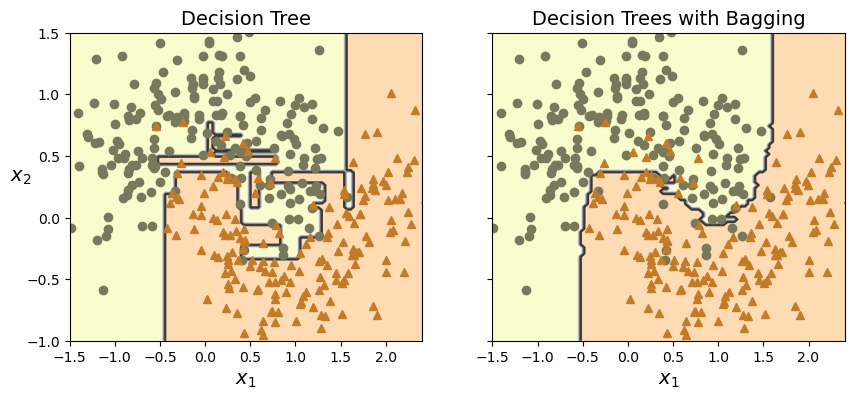

In [63]:
# extra code – this cell generates figure


def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap="Wistia")
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)


tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

In [64]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [65]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


0.92

In [66]:
rnd_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42
)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [67]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500,
    n_jobs=-1,
    random_state=42,
)

Feature importance

In [68]:
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.1 sepal length (cm)
0.02 sepal width (cm)
0.41 petal length (cm)
0.47 petal width (cm)


BOOSTING

In [69]:
# this is also called hypothesis boosting combining weak learners into a strong learner
# the following code trains an AdaBoost classifier based on 30 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42,
)
ada_clf.fit(X_train, y_train)
# if ada_clf is overfitting you can try reducing the number of estimators or more strongly regularizing the base estimator

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [70]:
# Gradient Boosting
# sequentially adding predictors to an ensemble, each one correcting its predecessor
# this tries to fit the new predictor to the residual errors made by the previous predictor
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # quadratic data set with some noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [71]:
# next we train a second DecisionTreeRegressor on the residual errors made by the first predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [72]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)
# this gives us an ensamble containing three trees it can make predictions on a new instance simply by adding up the predictions of all the trees

DecisionTreeRegressor(max_depth=2, random_state=44)

In [73]:
X_new = np.array([[-0.4], [0.0], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [74]:
# using the sci-kit learn GradientBoostingRegressor class to train GBRT ensemble it has hyperparameters to control the growth of Decision Trees as well as the ensemble training such as the number of trees
# this creates the same ensemble as the previous one
gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42
)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [75]:
# this is esentially early stopping with a little paitence
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42,
)
gbrt_best.fit(X, y)
# supports subsample hyperparameter as well which specifies the fraction of training instances to be used for training each tree

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [76]:
gbrt_best.n_estimators_

92

Text(0.5, 0, '$x_1$')

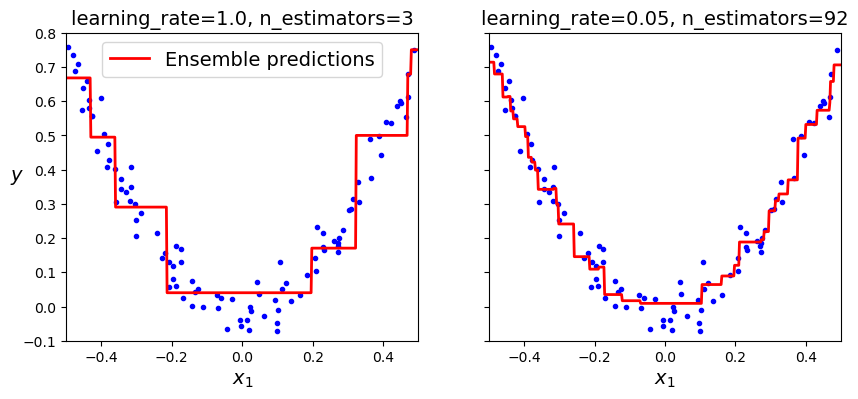

In [77]:
def plot_predictions(
    regressors, X, y, axes, style, label=None, data_style="b.", data_label=None
):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(
    [gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-", label="Ensemble predictions"
)
plt.title(f"learning_rate={gbrt.learning_rate}, " f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(
    f"learning_rate={gbrt_best.learning_rate}, "
    f"n_estimators={gbrt_best.n_estimators_}"
)
plt.xlabel("$x_1$")

In [78]:
housing = pd.read_csv("../data/housing.csv")

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [79]:
# histogram based gradient boosting
# this is optimized for larger datasets this bins input features and replaces them with integers this speeds up training and often improves performance
# this can help control overfitting but can also underfit if there are too few bins
# early stopping automatically activated if instnaces greater than 10000
# subsampling not supported n_estimators is renamed to max_iter
# the only decision tree hyperparameters that can be tweaked are max_leaf_nodes, min_samples_leaf, and max_depth
# HBC classes support both catagorical features and missing values however cataegorical features must be labeled from 0 to n-1 where n is the number of bins can use OrdinalEncoder for this

hgb_reg = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), ["ocean_proximity"]), remainder="passthrough"
    ),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42),
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [80]:
#stacking
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42)),
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv = 5
)
stacking_clf.fit(X_train, y_train)
# stacking works better than voting because it trains the final predictor on the predictions of the individual predictors

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [83]:
print('Voting classifier score:', voting_clf.score(X_test, y_test))
print('Stacking classifier score:', stacking_clf.score(X_test, y_test))

Voting classifier score: 0.912
Stacking classifier score: 0.92
